## Implementing SPADE Algo


In [3]:
import bokeh
from bokeh.plotting import show
import matplotlib.pyplot as plt

import flowkit as fk

bokeh.io.output_notebook()
%matplotlib inline

_ = plt.ioff()

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import numpy as np

Loading BokehJS ...

Importing the fcs object using path

In [4]:
fcs_path = 'nbt.1991-SD1.fcs'

In [5]:
sample = fk.Sample(fcs_path, ignore_offset_error=True)
#sample = fk.Sample.__init__(self=fcs_path,fcs_path_or_data=fcs_path, sample_id='nbt')

/Users/tanvijain/Documents/GitHub/FlowKit/testpy3/lib/python3.9/site-packages/flowio/flowdata.py:344: UserWarning: FCS file nbt.1991-SD1.fcs reported incorrect data offset. Attempting to parse data section, but event data should be reviewed before trusting this file.
  warn(warn_msg)


In [6]:
sample

Sample(v3.0, nbt.1991-SD1.fcs, 2 channels, 50000 events)

In [7]:
sample.pns_labels

['marker1', 'marker2']

In [8]:
p = sample.plot_scatter(
    'marker1', 'marker2',
    source='raw', y_min=0., y_max=130, x_min=0., x_max=280, color_density=True
)

In [9]:
show(p)

In [10]:
asinh_xform = fk.transforms.AsinhTransform('asinh', param_t=262144, param_m=5, param_a=2.0)
sample.apply_transform(asinh_xform)

p = sample.plot_scatter(1, 2, source='xform', subsample=True)
show(p)

### Density dependent downsampling

Using pseudocode from Qiu, P., Simonds, E., Bendall, S. et al. Extracting a cellular hierarchy from high-dimensional cytometry data with SPADE. Nat Biotechnol 29, 886–891 (2011). https://doi.org/10.1038/nbt.1991 (https://static-content.springer.com/esm/art%3A10.1038%2Fnbt.1991/MediaObjects/41587_2011_BFnbt1991_MOESM15_ESM.pdf)

"SPADE views a cytometry data set as a high-dimensional point cloud, where each point in the cloud is one cell and the dimension of the cloud is the number of cellular markers. Dense regions of the cloud correspond to abundant cell types, whereas low-density regions correspond to rare cell types or cells in transition between abundant cell types. Most clustering algorithms rely on the density variation to identify abundant cell types6,7,8,9,10,12. In contrast, SPADE down-samples the data in a density-dependent fashion to remove the density variation."

Pseudocode:

![Screenshot 2023-07-05 at 10.34.34 AM.png](<attachment:Screenshot 2023-07-05 at 10.34.34 AM.png>)

(transform data here if needed)
We will take a random 2000 events using subsampling, calculate the distance of each of their nearest neighbour, take median of these distances and store it

In [17]:
sample.subsample_events(subsample_count=2000)

In [18]:
np_events = sample.get_events(source='xform', subsample=2000)

In [19]:
np_events.shape

(2000, 2)

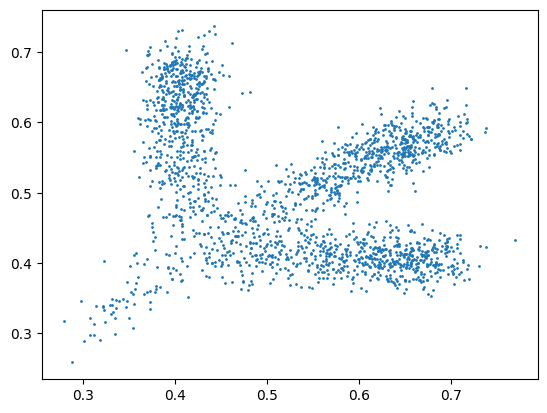

In [20]:
plt.scatter(*np_events.T, s=1)
plt.show()

Finding nearest neighbour of all subsample events (storing distance and indices using sklearn)

In [21]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(np_events)

In [22]:
distances, indices = nbrs.kneighbors(np_events)

In [23]:
distances


array([[0.        , 0.00218131],
       [0.        , 0.00114493],
       [0.        , 0.00312361],
       ...,
       [0.        , 0.00290765],
       [0.        , 0.01194134],
       [0.        , 0.00130422]])

storing median distance of all nearest neighbours

In [24]:
med_min_dist = np.median(distances, axis=0)[1]

In [25]:
med_min_dist

0.0028063077200109537

In [26]:
alpha = 1
dist_threshold = med_min_dist * alpha

In [27]:
dist_threshold

0.0028063077200109537

Calculating all neighbours for all events using `dist_threshold` radius neighbour classifier

In [28]:
events = sample.get_events(source='xform')
events.shape

(50000, 2)

In [29]:
neighbours = nbrs.radius_neighbors(events, radius=dist_threshold, return_distance=False)

Storing the number of neighbours in each event's `dist_threshold` radius distance as `local_density` array

In [30]:
local_density = np.empty(0)
for x in range(neighbours.size):
    local_density = np.append(local_density, neighbours[x].size)

In [31]:
local_density

array([1., 1., 1., ..., 3., 0., 0.])

In [32]:
local_density.shape

(50000,)

Calculating the probability of keeping cell `i` in array `keep_cell_prob` using equation(i) in Qui et. al 


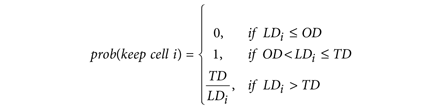

In [33]:
np.percentile(local_density, 1)

0.0

In [39]:
np.percentile(local_density, 50)

1.0

In [40]:
keep_cell_prob = np.empty(0)
outlier_density = np.percentile(local_density, 1)
target_density = np.percentile(local_density, 3)
for x in range(local_density.size):
    if local_density[x] <= outlier_density:
        keep_cell_prob = np.append(keep_cell_prob, 0)
    elif (outlier_density < local_density[x]) & (local_density[x] <= target_density):
        keep_cell_prob = np.append(keep_cell_prob,1)
    else:
        keep_cell_prob = np.append(keep_cell_prob, (target_density/local_density[x]))


Using `keep_cell_prob` to determine outcome of keeping event for clustering

In [41]:
import random
keep_cell = np.empty(0)
def event_trial(cell_prob):
    if random.random() <= cell_prob:
        return 0
    else:
        return 1
    
for x in range(keep_cell_prob.size):
    keep_cell = np.append(keep_cell, event_trial(keep_cell_prob[x]))


In [45]:
keep_cell[0:100]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [42]:
kept_events = events[keep_cell.astype('bool'), :]

In [43]:
kept_events.shape

(50000, 2)

In [ ]:
from scipy.stats import gaussian_kde
plt.subplot(1,2,1)

xy = np.vstack([*kept_events[::].T])
z = gaussian_kde(xy)(xy)
plt.scatter(*kept_events[::].T, s=1, c=z)

xy = np.vstack([*events[::].T])
z = gaussian_kde(xy)(xy)
plt.subplot(1,2,2)
plt.scatter(*events[::].T, s=1,c=z)
plt.show()

### Aglomerative Clustering

SPADE employs a variant of an agglomerative hierarchical clustering algorithm. At the beginning of the first iteration of the agglomerative process, each cell forms its own cluster. One cell is randomly chosen and grouped with its nearest neighbor, defined by single linkage L1 distance. Then, another cell is randomly chosen from the remaining cells and grouped with its nearest neighbor, if the nearest neighbor has not already been grouped with other cells in the current iteration. After all the cells are examined (that is, either chosen or grouped with other cells), the first iteration ends and the number of clusters is reduced by approximately half. The same procedure is repeated in the second iteration to further reduce the number of clusters by approximately half. The iterative process continues until the number of remaining clusters reaches a user-defined threshold. Clustering simplifies the point cloud, distilling it into abutting cell clusters that span the full space occupied by the original cloud. The scale of the simplification can be controlled by adjusting the desired number of clusters.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
clustering = AgglomerativeClustering(n_clusters=10, metric="l1",linkage='single').fit(kept_events)

In [ ]:
plt.scatter(*kept_events.T, s=1, c=clustering.labels_)
plt.show()

### Step 3: Minimum Spanning Tree (MST) construction

"SPADE uses Boruvka's algorithm23 to construct a minimum spanning tree (MST) that links the cell clusters. Each cell cluster is one tree node, and is represented by its median marker expressions. Briefly, we start from a graph with no edges, and iteratively add edges. In each iteration, we randomly select one connected subgraph, calculate its single linkage L1 distances to all nodes outside the randomly selected subgraph, and add an edge that corresponds to the smallest single linkage distance. This process iterates until all nodes are connected. As the MST tends to connect clusters that are close to each other to achieve the minimum total edge length, the resulting tree approximates the shape of the point cloud."

In [ ]:
import networkx as nx

In [ ]:
nx.Graph.__init__(linkage_data)

In [ ]:
nx.minimum_spanning_tree(G=clustering,weight='single',algorithm='boruvka')

In [ ]:
sns.scatterplot(ax=axes[1], data=kept_events, x='marker1', y='marker2', hue=asc.labels_).set_title('With clustering')

In [ ]:
plt.figure(figsize =(6, 6))
plt.scatter(*kept_events[::10].T,c = AgglomerativeClustering(5, metric="l1",linkage='single').fit(kept_events), cmap ='rainbow')
plt.show()